mask_np shape: (1024, 1024), dtype: uint8
mask_np min: 0, max: 255


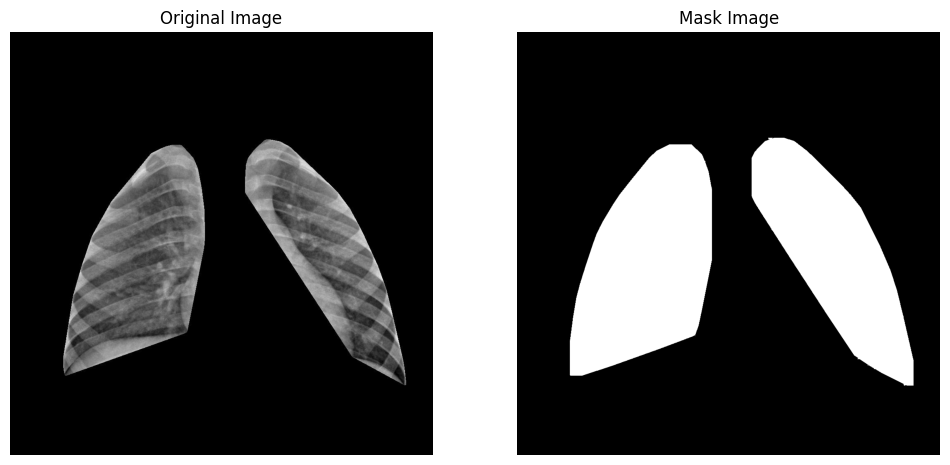

In [3]:
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

def create_mask(image):
    # 이미지에서 0이 아닌 부분을 선택하여 마스크 생성
    mask = (image > 0).float()
    
    # numpy array로 변환 및 차원 축소 (채널 축 제거)
    mask_np = mask.squeeze().cpu().numpy()
    
    # 데이터 타입 변환
    if mask_np.ndim == 3:
        mask_np = mask_np[0]  # 첫 번째 채널만 사용

    mask_np = (mask_np * 255).astype(np.uint8)
    
    # 디버깅 출력 추가
    print(f"mask_np shape: {mask_np.shape}, dtype: {mask_np.dtype}")
    print(f"mask_np min: {mask_np.min()}, max: {mask_np.max()}")

    # Convex Hull 적용
    contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    new_mask = np.zeros_like(mask_np)
    
    for contour in contours:
        hull = cv2.convexHull(contour)
        cv2.drawContours(new_mask, [hull], -1, 1, thickness=cv2.FILLED)
    
    return torch.tensor(new_mask).unsqueeze(0).unsqueeze(0).float()  # (1, 1, H, W) 형태로 반환

# 데이터셋 경로
data_dir = "input/segmented_chest_xray"
phases = ['train', 'val', 'test']

# 이미지를 텐서로 변환하는 변환 정의
transform = transforms.Compose([
    transforms.ToTensor()  # 단순히 Tensor로 변환 (크기 조정 없음)
])

# 데이터셋 로드
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform) for x in phases}

# 데이터 로더 정의
dataloaders = {x: DataLoader(image_datasets[x], batch_size=1, shuffle=True) for x in phases}

# 샘플 이미지 로드
inputs, labels = next(iter(dataloaders['train']))
input_image = inputs[0]
label = labels[0]

# 마스크 생성
mask = create_mask(input_image)

# 원본 이미지와 마스크 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 원본 이미지
axes[0].imshow(input_image.permute(1, 2, 0).numpy(), cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")

# 마스크 이미지
axes[1].imshow(mask.squeeze().cpu().numpy(), cmap='gray')
axes[1].set_title("Mask Image")
axes[1].axis("off")

plt.show()
